<a href="https://colab.research.google.com/github/amrahmani/Marketing/blob/main/AIMarketing_Ch3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Target new customers showing high response likelihood via characteristic analysis for effective direct marketing.**

Number of new customers (enrolled since 2013-12-14): 220

--- K-Means Clustering on New Customers ---


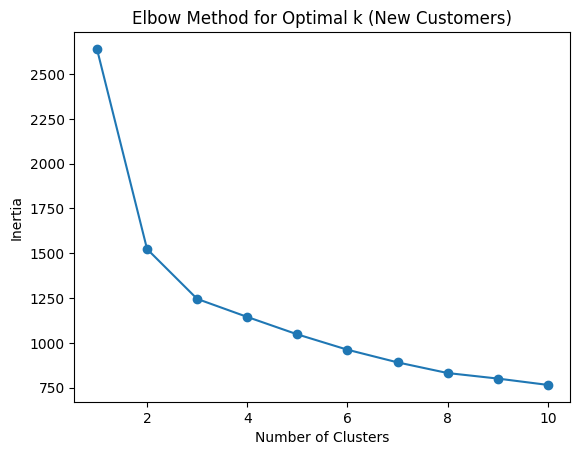


New customers assigned to 3 clusters.
cluster
0    116
1     60
2     44
Name: count, dtype: int64

--- Logistic Regression for Response Prediction (New Customers) ---

--- Analyzing Clustering Results ---

Cluster Profiles (Mean Values):
               Income    Recency    MntWines  MntFruits  MntMeatProducts  \
cluster                                                                    
0        39967.920354  50.284483   38.896552   3.137931        16.422414   
1        66532.650000  48.950000  434.133333  21.133333       161.850000   
2        82068.386364  48.795455  528.409091  92.181818       531.613636   

         MntFishProducts  MntSweetProducts  MntGoldProds  NumWebPurchases  \
cluster                                                                     
0               4.344828          3.284483     10.103448         1.836207   
1              38.850000         21.666667     38.633333         5.833333   
2             112.204545         81.886364     85.840909         4.4318

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


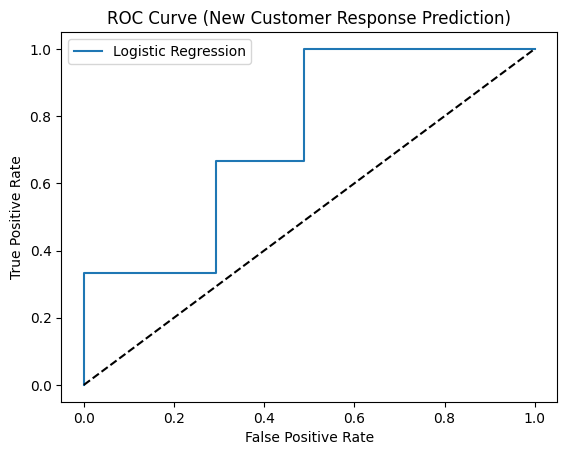

In [3]:
import pandas as pd
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

# Load the dataset
df = pd.read_csv('https://raw.githubusercontent.com/amrahmani/Marketing/main/marketing_campaign_data.csv')

# Convert 'Dt_Customer' to datetime objects
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])

# --- Step 1: Define "New Customers" Dynamically ---
# Find the most recent enrollment date
most_recent_enrollment = df['Dt_Customer'].max()

# Calculate the cutoff date for the last 6 months
cutoff_date = most_recent_enrollment - timedelta(days=6 * 30) # Approximately 6 months

# Filter for new customers
new_customers_df = df[df['Dt_Customer'] >= cutoff_date].copy()
print(f"Number of new customers (enrolled since {cutoff_date.strftime('%Y-%m-%d')}): {len(new_customers_df)}")

# --- Step 2: Clustering on New Customers (using K-Means) ---
print("\n--- K-Means Clustering on New Customers ---")

# Select features for clustering
features_for_clustering = ['Income', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts',
                           'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
                           'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
                           'NumWebVisitsMonth']
clustering_data = new_customers_df[features_for_clustering].copy()

# Handle missing values
imputer_cluster = SimpleImputer(strategy='mean')
clustering_data_imputed = pd.DataFrame(imputer_cluster.fit_transform(clustering_data),
                                        columns=clustering_data.columns)

# Scale the data
scaler_cluster = StandardScaler()
scaled_clustering_data = scaler_cluster.fit_transform(clustering_data_imputed)
scaled_clustering_df = pd.DataFrame(scaled_clustering_data, columns=clustering_data.columns)

# Determine the optimal number of clusters (Elbow method)
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(scaled_clustering_data)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k (New Customers)')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# Apply K-Means with a chosen k (let's assume k=3 based on the plot)
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
new_customers_df['cluster'] = kmeans.fit_predict(scaled_clustering_data)

print(f"\nNew customers assigned to {n_clusters} clusters.")
print(new_customers_df['cluster'].value_counts())

# --- Step 3: Classification Models on New Customers (using Logistic Regression) ---
print("\n--- Logistic Regression for Response Prediction (New Customers) ---")

# Prepare data for classification
X = new_customers_df[['Income', 'Recency', 'MntWines', 'NumWebPurchases', 'NumWebVisitsMonth', 'cluster']]
y = new_customers_df['Response']

# Identify numerical and categorical features
numerical_features_lr = ['Income', 'Recency', 'MntWines', 'NumWebPurchases', 'NumWebVisitsMonth']
categorical_features_lr = ['cluster']

# Create preprocessing pipelines for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create a column transformer to apply different transformations to different columns
preprocessor_lr = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features_lr),
        ('cat', categorical_transformer, categorical_features_lr)])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create and train the Logistic Regression model
logistic_model = Pipeline(steps=[('preprocessor', preprocessor_lr),
                                 ('classifier', LogisticRegression(random_state=42, solver='liblinear'))])

logistic_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = logistic_model.predict(X_test)
y_prob = logistic_model.predict_proba(X_test)[:, 1]

# --- Step 4: Analyze the Results ---
print("\n--- Analyzing Clustering Results ---")
# Analyze cluster profiles (mean values for numerical features, mode for categorical)
cluster_profiles = new_customers_df.groupby('cluster')[features_for_clustering + ['Response']].mean()
print("\nCluster Profiles (Mean Values):")
print(cluster_profiles)

# Analyze response rate per cluster
response_rate_per_cluster = new_customers_df.groupby('cluster')['Response'].mean()
print("\nResponse Rate per Cluster:")
print(response_rate_per_cluster)

print("\n--- Analyzing Logistic Regression Results ---")
# Evaluate the model
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAUC-ROC Score:", roc_auc_score(y_test, y_prob))

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label='Logistic Regression')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (New Customer Response Prediction)')
plt.legend()
plt.show()

**Task 1:**
Analyze the characteristics of the clusters identified in Activity 2. Calculate descriptive statistics (mean, median, standard deviation) for key features within each cluster. Create a "segment profile" for each cluster, summarizing their distinct characteristics (e.g., demographics, spending habits, engagement).